## Setup

In [3]:
import os
import glob
from PIL import Image
from collections import namedtuple
import torch
import torchvision.transforms as transforms
import numpy as np
import h5py
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from srresnet import ConvolutionalBlock, SubPixelConvolutionalBlock, ResidualBlock, SRResNet

## Load Model from Checkpoint

In [8]:
path = '../saved_models/saved_models_private'
model = 'best_model-epoch=274-val_loss=0.28.ckpt'
#checkpoint = torch.load(os.path.join(path, model), 
#                        map_location=torch.device('cpu'))

In [9]:
#checkpoint.keys()

In [10]:
#checkpoint["state_dict"].keys()

In [11]:
#print(checkpoint["hyper_parameters"])

In [12]:
hyperparams = {
                'debug': False,
                'data_dir': '/work/ka1176/frauke/super-resolution/data',
                'output_path': '/work/ka1176/frauke/super-resolution/nni/nni-experiments/mo8u06h1/trials/ZAtHq/preds.h5',
                'save_model_path': '/work/ka1176/frauke/super-resolution/nni/nni-experiments/mo8u06h1/trials/ZAtHq/saved_models_private',
                'batch_size': 4,
                'learning_rate': 0.001,
                'scaling_factor': 4,
                'n_channels': 10,
                'large_kernel_size': 9,
                'small_kernel_size': 3,
                'n_blocks': 28,
                'n_epochs': 1000,
                'nni': True,
                'logger': True,
                'checkpoint_callback': True,
                'default_root_dir': None,
                'gradient_clip_val': 0,
                'process_position': 0,
                'num_nodes': 1, 'num_processes': 1,
                'gpus': 1, 'auto_select_gpus': False,
                'tpu_cores': None, #<function _gpus_arg_default at 0x7fd9a6fab0d0>, 
                'log_gpu_memory': None,
                'progress_bar_refresh_rate': None,
                'overfit_batches': 0.0,
                'track_grad_norm': -1,
    }

In [14]:
# convert dictionary to object to access values via dot notation
#args = namedtuple("ObjectName", checkpoint["hyper_parameters"].keys())(*checkpoint["hyper_parameters"].values())
args = namedtuple("ObjectName", hyperparams.keys())(*hyperparams.values())

In [15]:
args.debug

False

In [16]:
#model = SRResNet(args)

In [17]:
model = SRResNet.load_from_checkpoint(os.path.join(path, model), 
                                      map_location=torch.device('cpu'),
                                      args=args)

[2022-08-29 22:51:18] INFO (torch.distributed.nn.jit.instantiator/MainThread) Created a temporary directory at /tmp/tmp2z32hr7t
[2022-08-29 22:51:18] INFO (torch.distributed.nn.jit.instantiator/MainThread) Writing /tmp/tmp2z32hr7t/_remote_module_non_sriptable.py
times subpixel: 2


In [18]:
model.eval()

SRResNet(
  (conv_block1): ConvolutionalBlock(
    (conv_block): Sequential(
      (0): Conv2d(3, 10, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (1): PReLU(num_parameters=1)
    )
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (conv_block1): ConvolutionalBlock(
        (conv_block): Sequential(
          (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): PReLU(num_parameters=1)
        )
      )
      (conv_block2): ConvolutionalBlock(
        (conv_block): Sequential(
          (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (1): ResidualBlock(
      (conv_block1): ConvolutionalBlock(
        (conv_block): Sequential(
          (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1)

## Load low resolution Images

In [19]:
path_lr = '../data/LR_private'
imgs_lr = glob.glob(f"{path_lr}/*.png")
imgs_lr[:5]

['../data/LR_private/02b9a2f3-3be4-4964-9095-4b0c77f6f085.png',
 '../data/LR_private/f00a2e6c-6fef-465d-af6a-4853c89644c9.png',
 '../data/LR_private/3a9cb351-9605-499b-98c1-53500ddf4dde.png',
 '../data/LR_private/4ad074a5-0c53-4d8b-86e3-a532e361404a.png',
 '../data/LR_private/daa5d865-f726-48a8-8f0c-fab2109b8a24.png']

In [20]:
path_hr = '../data/HR_private'
imgs_hr = glob.glob(f"{path_hr}/*.png")
imgs_hr[:5]

['../data/HR_private/02b9a2f3-3be4-4964-9095-4b0c77f6f085.png',
 '../data/HR_private/f00a2e6c-6fef-465d-af6a-4853c89644c9.png',
 '../data/HR_private/3a9cb351-9605-499b-98c1-53500ddf4dde.png',
 '../data/HR_private/4ad074a5-0c53-4d8b-86e3-a532e361404a.png',
 '../data/HR_private/daa5d865-f726-48a8-8f0c-fab2109b8a24.png']

In [21]:
print(len(imgs_lr))

622


## Preprocessing

In [22]:
# to tensor
# normalize
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

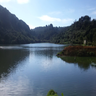

In [23]:
# load image
n = 600 #100
path = imgs_lr[n]
img_lr = Image.open(path)#np.asarray(Image.open(path))
img_lr#[0][:5]

In [24]:
x = transform(img_lr)
x.shape

torch.Size([3, 96, 96])

## Apply Model

In [25]:
# expand dimension for batch dim
X = x[None,:] # (bs, channel, width, height)
X.shape

torch.Size([1, 3, 96, 96])

In [26]:
y = model(X)
y = y
y.shape

torch.Size([1, 3, 384, 384])

## Plot resulting Image

In [27]:
torch.max(y), torch.min(y)

(tensor(1., grad_fn=<MaxBackward1>), tensor(-1., grad_fn=<MinBackward1>))

In [28]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
mean_rev = -(mean/std)
std_rev = 1/std
un_transform = transforms.Compose([transforms.Normalize(mean_rev, std_rev)])

In [29]:
y = un_transform(y.squeeze())

In [30]:
img_hr = y.squeeze()
print(img_hr.shape)
img_hr = np.swapaxes(img_hr, 0, 2)
print(img_hr.shape)
img_hr = np.swapaxes(img_hr, 0, 1)
print(img_hr.shape)

torch.Size([3, 384, 384])
torch.Size([384, 384, 3])
torch.Size([384, 384, 3])


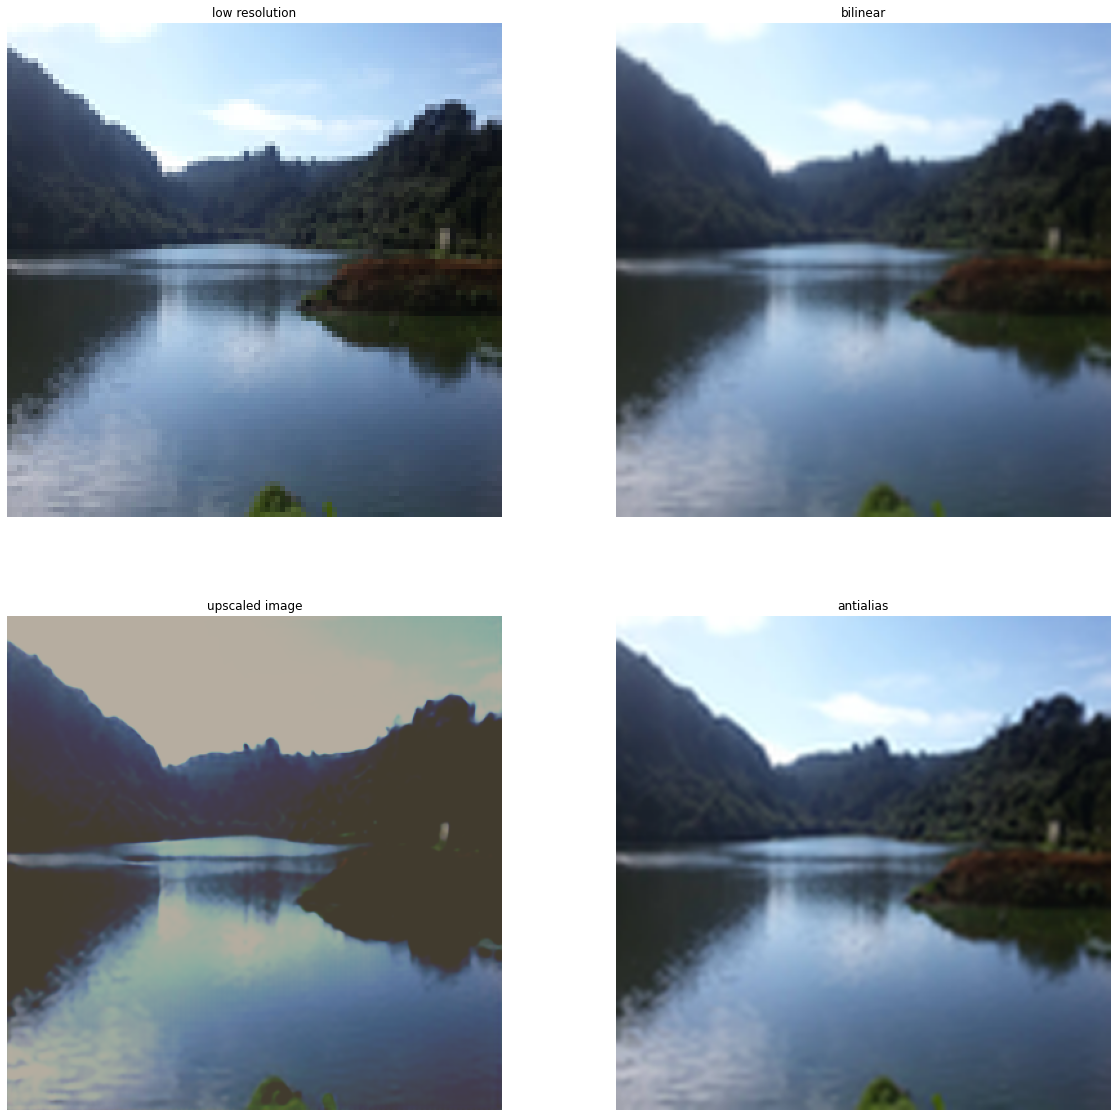

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes[0,0].imshow(img_lr)
axes[0,0].axis('off')
axes[0,0].set_title('low resolution')
axes[0,1].imshow(img_lr.resize((384, 384), Image.BILINEAR))
axes[0,1].axis('off')
axes[0,1].set_title('bilinear')
axes[1,0].imshow(img_hr.detach().numpy())
axes[1,0].axis('off')
axes[1,0].set_title('upscaled image')
axes[1,1].imshow(img_lr.resize((384, 384), Image.ANTIALIAS))
axes[1,1].axis('off')
axes[1,1].set_title('antialias')
#plt.savefig("example_prediction.png")
plt.show()

# Compare MSE

In [171]:
img_hr = img_hr.detach().numpy()
img_hr.shape 

(384, 384, 3)

In [172]:
img_bilin = np.asarray(img_lr.resize((384, 384), Image.BILINEAR))
img_bilin.shape

(384, 384, 3)

In [173]:
img_anti = np.asarray(img_lr.resize((384, 384), Image.ANTIALIAS))
img_anti.shape

(384, 384, 3)

In [174]:
path = imgs_hr[n]
img_orig = np.asarray(Image.open(path))
img_orig.shape

(384, 384, 3)

In [175]:
def mse(A, B):
    mse = ((A - B)**2).mean(axis=None)
    return mse

In [176]:
print(f'mse orig - pred: {mse(img_orig/255, img_hr)}')
print(f'mse orig - pred: {mse(img_orig/255, img_bilin/255)}')
print(f'mse orig - pred: {mse(img_orig/255, img_anti/255)}')

mse orig - pred: 0.018550109357867925
mse orig - pred: 0.0013626166293212547
mse orig - pred: 0.001204971982041273


In [177]:
# estimate mse per batch
bs = 10 # batch size
# assume same error for each image in batch
print(f'mse orig - pred: {mse(img_orig/255, img_hr)*10}')
print(f'mse orig - pred: {mse(img_orig/255, img_bilin/255)*10}')
print(f'mse orig - pred: {mse(img_orig/255, img_anti/255)*10}')

mse orig - pred: 0.18550109357867925
mse orig - pred: 0.013626166293212547
mse orig - pred: 0.01204971982041273
